## 3.1 MLP の構築と学習

In [1]:
## 手書き文字を判別する MLP を作成

import torch
from torch import nn

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

In [2]:
from torch import optim
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
Y = digits.target

# NumPy の ndarray を PyTorch の Tensor に変換
X = torch.tensor(X, dtype = torch.float32)
Y = torch.tensor(Y, dtype = torch.int64)

# ソフトマックスクロスエントロピー
loss_fn = nn.CrossEntropyLoss()

# Adam
optimizer = optim.Adam(net.parameters())

# 損失関数のログ
losses = []

# 200回イテレーションを回す
for epoc in range(200):
    
    # 前回の backward メソッドで計算された勾配の値を削除
    optimizer.zero_grad()
    
    # 線形モデルで y の予測値を計算
    y_pred = net(X)
    
    # MSE loss と w による微分を計算
    loss = loss_fn(y_pred, Y)
    loss.backward()
    
    # 勾配を更新する
    optimizer.step()
    
    # 収束確認のために loss を記録しておく
    losses.append(loss.item())

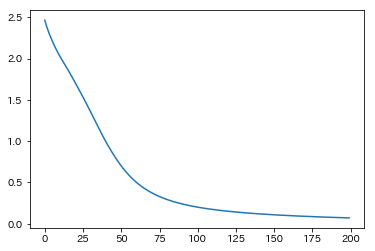

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

## 3.2 Dataset と DataLoader

### 3.2.1 Dataset と DataLoader

Dataset と DataLoader は以下のことを簡単に行える

- ミニバッチ学習
- データのシャッフル
- 並列処理

TensorDataset は Dataset を継承したクラスで特徴量X とラベルY をまとめるコンテナである。  
この TensorDataset を DataLoader に渡すことで、forループでデータの一部のみを簡単に受け取れるようになる。  
TensorDataset には Tensor のみ渡すことができ、Variable は渡せない点に注意してください。  

In [4]:
## TensorDataset を DataLoader に渡してデータの一部のみを簡単に受け取る例

from torch.utils.data import TensorDataset, DataLoader

# Dataset を作成
ds = TensorDataset(X, Y)
print(ds.tensors)

# 異なる順番で64個ずつデータを返す DataLoader を作成
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

#　最適化を実行
losses = []
for epoc in range(20):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yy は64個分のみ受け取れる
        y_pred = net(xx)  # 線形モデルで y の予測値を計算
        loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
        optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
        loss.backward()
        optimizer.step()  # 勾配を更新する
        running_loss += loss.item()
    losses.append(running_loss)

(tensor([[ 0.,  0.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1.,  ...,  6.,  0.,  0.],
        [ 0.,  0.,  2.,  ..., 12.,  0.,  0.],
        [ 0.,  0., 10.,  ..., 12.,  1.,  0.]]), tensor([0, 1, 2,  ..., 8, 9, 8]))


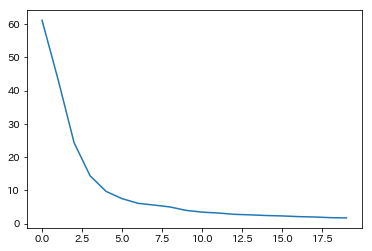

In [5]:
plt.plot(losses)
plt.show()

Dataset は独自に作ることもでき、大量の画像ファイルを全てメモリ上に保存せず、都度読み込む方式で学習することも出来、様々な使い方がある。

## 3.3 学習効率化の Tips

NN は非常に表現力の高いモデルですが、一方で訓練データに適合しすぎて他のデータに適用できなかったり、あるいは訓練が不安定で長い時間がかかったりする問題がある。ここではそれらを克服する2つの代表的な手法である Dropout と Batch Normalization を説明する。  

### 3.3.1 Dropout による正則化

NN に限らず、ML の共通の問題として過学習が挙げられる。過学習とは訓練用のデータにパラメータが最適化されすぎて他のデータでの判別性能がむしろ下がってしまう現象である。特に深い NN はパラメータが多く、十分なデータが得られないとか学習師がである。

In [6]:
# 3.1節で使用したネットワークをより深くしたコード１

# データを訓練用と検証用に分割
from sklearn.model_selection import train_test_split

# 全体の30%用は検証用
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)

# 層を積み重ねて深い NN を構築する
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 訓練用データで DataLoader を作成
ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [7]:
# 3.1節で使用したネットワークをより深くしたコード２

train_losses = []
test_losses = []
for epoc in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        # xx, yy は64個分のみ受け取れる
        y_pred = net(xx)  # 線形モデルで y の予測値を計算
        loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
        optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
        loss.backward()
        optimizer.step()  # 勾配を更新する
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

過学習を抑えることで正則化（Regularization）と言う。正則化には様々な方法がありますが、NN では Dropout というランダムにいくつかのノード（変数の次元）を意図的に使用しないという方法がよく用いられる。 Dropout はネットワーク訓練時のみに行い、予測時には使用しないのが通常である。PyTorch ではモデルの train と eval メソッドでこの挙動を切り替えることが出来る。

In [8]:
## train と eval メソッドで Dropout の挙動を切り替える１

# 確率0.5でランダムに変数の次元を捨てる Dropout を各層に追加
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
)

In [9]:
## train と eval メソッドで Dropout の挙動を切り替える２

optimizer = optim.Adam(net.parameters())

train_losses_dropout = []
test_losses_dropout = []
for epoc in range(100):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    for i, (xx, yy) in enumerate(loader):
        # xx, yy は64個分のみ受け取れる
        y_pred = net(xx)  # 線形モデルで y の予測値を計算
        loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
        optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
        loss.backward()
        optimizer.step()  # 勾配を更新する
        running_loss += loss.item()
    train_losses_dropout.append(running_loss / i)
    # ネットワークを評価モードにして、検証データの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses_dropout.append(test_loss.item())

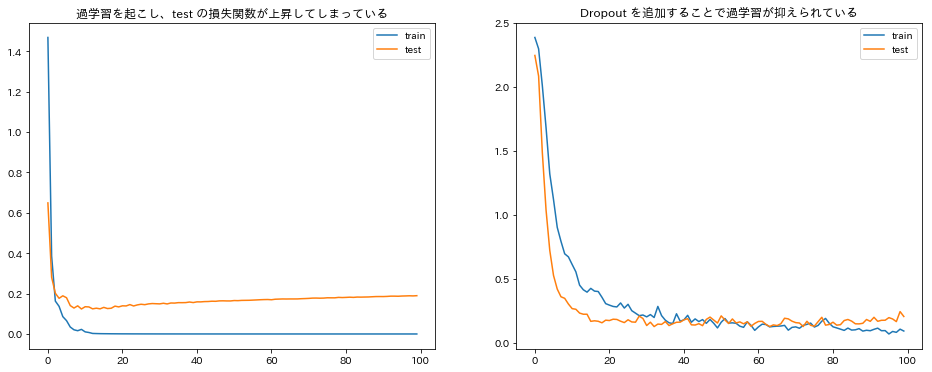

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("過学習を起こし、test の損失関数が上昇してしまっている")
ax1.legend()
ax2.plot(train_losses_dropout, label="train")
ax2.plot(test_losses_dropout, label="test")
ax2.set_title("Dropout を追加することで過学習が抑えられている")
ax2.legend()
plt.show()

### 3.3.2 Batch Normalization による学習の加速

SGD を使用した NN の学習では各変数の次元が同じような値の範囲を取ることが大事である。1層のみの線形モデルなどでは事前にデータの正規化を行えばいいが、深い NN では層を進むに連れてどんどんデータの分布が変わってしまうため、入力データの正規化だけでは不十分である。また、そもそも前の層の学習に従ってパラメータが変動し、後ろの層の学習が不安定になってしまうという問題がある。  
こういった問題がを緩和し、学習を安定化、加速させる方法として Batch Normalization がある。Batch Normalization も訓練時のみに適用し、評価時には使用しないので Dropout と同様に train と eval メソッドを使用して Batch Normalization を切り替える。

In [11]:
## train と eval メソッドで Batch Normalization の挙動を切り替える

net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, 10)
)

In [12]:
## train と eval メソッドで Dropout の挙動を切り替える２

optimizer = optim.Adam(net.parameters())

train_losses_btachnorm = []
test_losses_btachnorm = []
for epoc in range(100):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    for i, (xx, yy) in enumerate(loader):
        # xx, yy は64個分のみ受け取れる
        y_pred = net(xx)  # 線形モデルで y の予測値を計算
        loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
        optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
        loss.backward()
        optimizer.step()  # 勾配を更新する
        running_loss += loss.item()
    train_losses_btachnorm.append(running_loss / i)
    # ネットワークを評価モードにして、検証データの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses_btachnorm.append(test_loss.item())

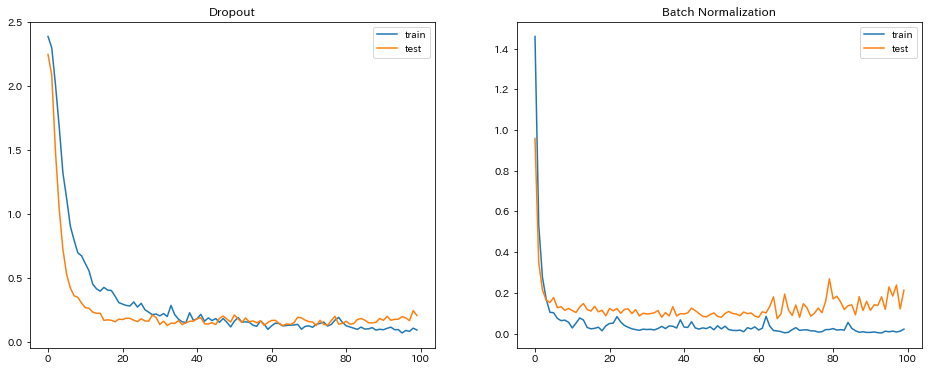

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(train_losses_dropout, label="train")
ax1.plot(test_losses_dropout, label="test")
ax1.set_title("Dropout")
ax1.legend()
ax2.plot(train_losses_btachnorm, label="train")
ax2.plot(test_losses_btachnorm, label="test")
ax2.set_title("Batch Normalization")
ax2.legend()
plt.show()

## 3.4 ネットワークのモジュール化

PyTorch はドジのネットワーク層を定義することが出来る。オブジェクト指向プログラミングで独自クラスを作るのと同じように、独自ネットワーク層を作ることで後で再利用しやすくなったり、これをパーツにしてより複雑なネットワークを作ったりすることが出来る。

### 3.4.1 独自のネットワーク層（カスタム層）を作る

nn.Module を継承したクラスを定義する。実は nn.Module は nn.Linear などのすべての層の基底クラスになっている。  
カスタム層を作る際には forward メソッドを実装すれば、自動微分まで可能になる。すでに、ある Variable 型の x を net(x) のようにしてネットワークによる予測を何回も実行してきたが、実は nn.Module の __call__ メソッドは内部で forward メソッドを使用しているのでこのように書ける。  
以下の例では活性化関数 ReLU と Dropout を含んだカスタムの線形層を作り、それを用いて3.3節のMLPを書いている。

In [19]:
## 活性化関数ReLU と Dropout　を含んだカスタムの線形層を作り、それを用いて MLP を記述

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x
        
mlp = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200, 10)
)

また、以下のように nn.Sequential を使用せず、すべてを nn.Module を継承したクラスで完結させることも出来る

In [24]:
## nn.Module を継承したクラスの利用

class MyMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200),
        self.ln2 = CustomLinear(200, 200),
        self.ln3 = CustomLinear(200, 200),
        self.ln4 = CustomLinear(200, out_features),
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x
    
mlp = MyMLP(64, 10)

### 3.5 まとめ